# Pneumonia diagnosis using Chest X-ray images

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [74]:
import os

import keras
import pandas as pd
import numpy as np
import seaborn as sns
import cv2

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix
from keras.metrics import categorical_accuracy

from keras.preprocessing.image import ImageDataGenerator

In [101]:
os.listdir('./data')

['.DS_Store', '.ipynb_checkpoints', 'test', 'train', 'val']

Not enough data in the initial validation set so we will transfer some images from training to validation set. 

In [104]:
 def move_from_to_n(src_dir,dst_dir, n):
        # move files, no duplicates!
        fs = os.listdir(src_dir)
        assert len(fs) >= n
        i=0
        targ = fs[-n:]
        # print('targ', targ)
        for f in targ:
            # print('move_from_to_n', i, f, src_dir, dst_dir)
            os.rename(src_dir+'/'+f, dst_dir+'/'+f)
            i+=1
        print('copied',i,src_dir,dst_dir)

In [105]:
move_from_to_n('./data/train/NORMAL/','./data/val/NORMAL/',50)

copied 50 ./data/train/NORMAL/ ./data/val/NORMAL/


In [106]:
move_from_to_n('./data/train/PNEUMONIA/','./data/val/PNEUMONIA/',50)

copied 50 ./data/train/PNEUMONIA/ ./data/val/PNEUMONIA/


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [109]:
total_images_train_normal = os.listdir('./data/train/NORMAL/')
total_images_train_pneumonia = os.listdir('./data/train/PNEUMONIA/')

In [110]:
total_images_train_pneumonia.pop(0)

'.DS_Store'

## Plot some examples of images (normal and affected lungs )

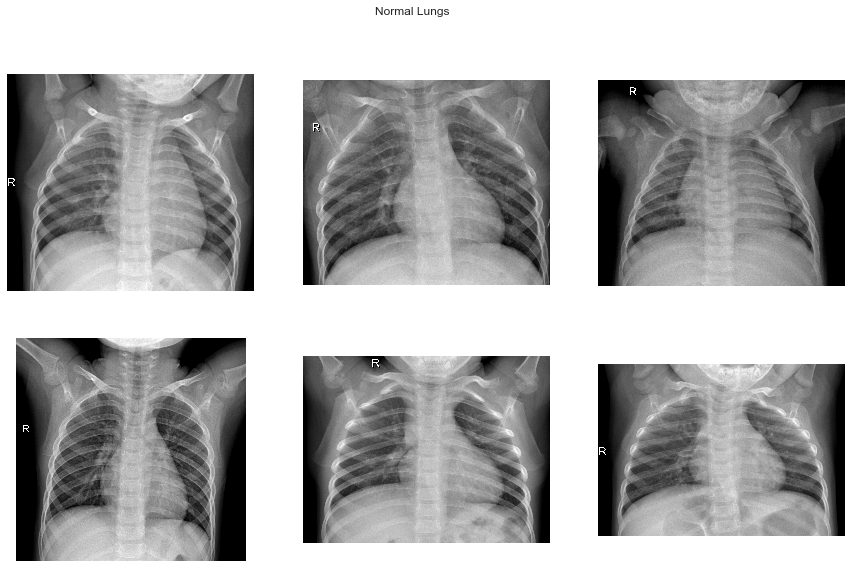

In [111]:
sample_normal = np.random.choice(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('./data/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

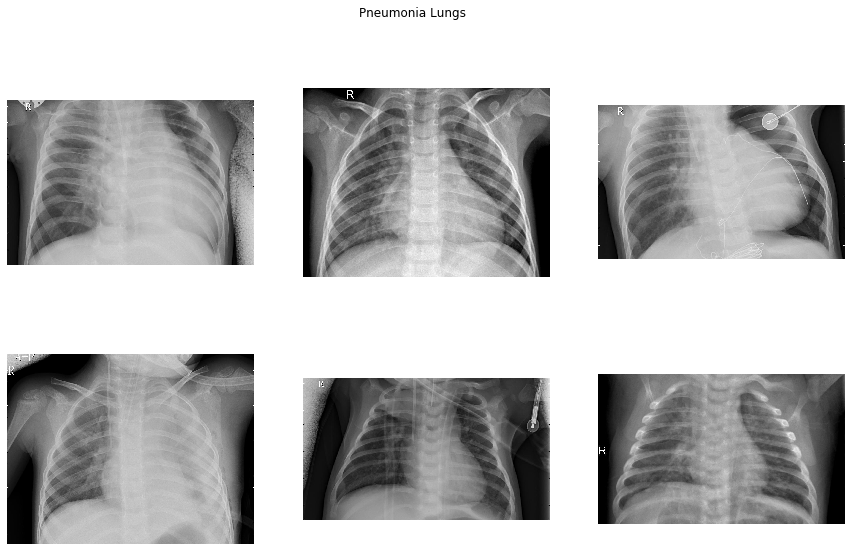

In [38]:
sample_pneumonia = np.random.choice(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('./data/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

## Data analysis 

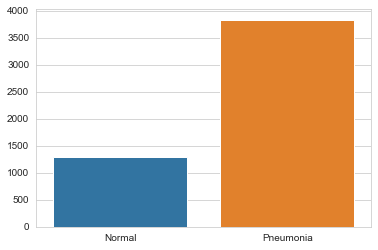

In [112]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

The dataset is imbalanced : more pneumonia than normal samples.

# Model

## Model parameters 

In [113]:
image_height = 150
image_width = 150
batch_size = 10
no_of_epochs  = 10

## Architecture of the model

In [114]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data augmentation

We will do some data augmentation before feeding the CNN in order to increase the training set and reduce overfitting. 

We apply Rescaling,Shearing,zooming and Rotation on our Training set and only rescaling on Test set.

In [115]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

In [128]:
training_set = train_datagen.flow_from_directory('./data/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

test_set = test_datagen.flow_from_directory('./data/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

val_set = test_datagen.flow_from_directory('./data/val',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            class_mode='binary')


Found 5132 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


We also add ReduceLROnPlateau callback on our model. It will reduce the learning rate by a factor of 2-10 once learning stagnates.

In [129]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [130]:
history = model.fit_generator(training_set,
                    steps_per_epoch=5132//batch_size,
                    epochs=no_of_epochs,
                    validation_data=val_set,
                    validation_steps=108//batch_size,
                    callbacks=callbacks
                   )

Epoch 1/10
513/513 [==============================] - 568s 1s/step - loss: 0.5014 - acc: 0.7836 - val_loss: 0.3327 - val_acc: 0.8700
Epoch 2/10
513/513 [==============================] - 640s 1s/step - loss: 0.3022 - acc: 0.8733 - val_loss: 0.5388 - val_acc: 0.7653
Epoch 3/10
513/513 [==============================] - 630s 1s/step - loss: 0.2454 - acc: 0.9023 - val_loss: 0.2790 - val_acc: 0.8980
Epoch 4/10
513/513 [==============================] - 591s 1s/step - loss: 0.2212 - acc: 0.9140 - val_loss: 0.3127 - val_acc: 0.8571
Epoch 5/10
513/513 [==============================] - 571s 1s/step - loss: 0.2224 - acc: 0.9084 - val_loss: 0.6223 - val_acc: 0.7551
Epoch 6/10
513/513 [==============================] - 556s 1s/step - loss: 0.1882 - acc: 0.9251 - val_loss: 0.2553 - val_acc: 0.8673
Epoch 7/10
513/513 [==============================] - 566s 1s/step - loss: 0.1852 - acc: 0.9244 - val_loss: 0.3760 - val_acc: 0.8367
Epoch 8/10
513/513 [==============================] - 525s 1s/step - 

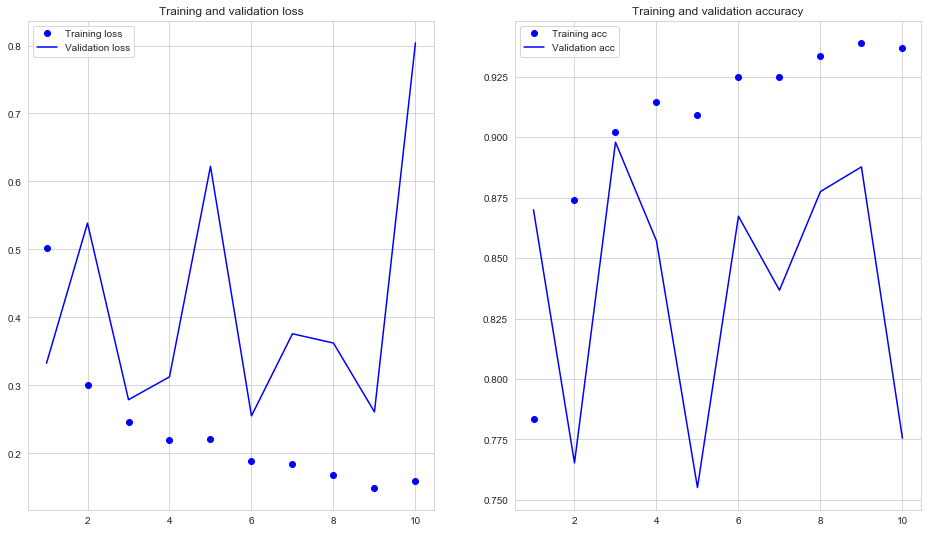

In [131]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [132]:
predictions = model.predict_generator(test_set, steps=624//batch_size+1, verbose=1)

63/63 [==============================] - 25s 389ms/step


In [134]:
preds = np.round(predictions)

(2, -1)

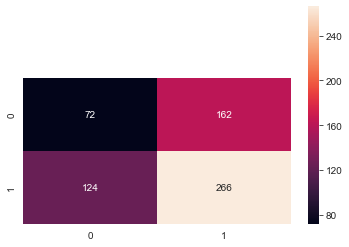

In [137]:
CM = confusion_matrix(test_set.classes, preds)
sns.heatmap(CM,annot=True,fmt="d")
plt.ylim([2, -1])

In [139]:
from sklearn.metrics import f1_score
f1_score(test_set.classes, preds)

0.6503667481662593